In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images'    #define your path
os.chdir(path)      #changing directory to path, this is where the dataset you download (linked below) should be and will unzip to.
path

'/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images'

In [ ]:
#unzipping file
!unzip 'your_zipped_images'  #Kaggle has a facial emotion dataset freely available https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset


In [ ]:
# IMPORTING LIBRARIES

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import dataset, dataloader

#import fastai
from fastai.data.all import *         
from fastai.vision.all import *
from fastai.text.all import *
from fastai.test_utils import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL as Image   
import time
import random
import copy
 
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from random import shuffle 
from shutil import copyfile
from shutil import copy
%matplotlib inline

import zipfile

The pretrained models to work with are here. Import them now, not when calling the model. It is much faster.

In [ ]:
from torchvision.models.resnet import  resnet34   

In [ ]:
!nvcc --version #checking for CUDA     #you might need this

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fa74ukva
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-fa74ukva
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=e2e9fae8d2a69da94d6fb5921d48d6c62ac118f9778bfe6ba30495837b2fe1e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-hwii71rd/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin


directory /content/drive/MyDrive/Colab Notebooks/Facial_emotion_images/src already exists
Out bin /content/drive/MyDrive/Colab Notebooks/Facial_emotion_images/result.out


**Here is the main information to feed the model:**

In [ ]:
# defining the path to our training images & test images
path = Path('/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images/train')      #define the paths to the unzipped images
t_path = Path('/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images/test')     #test image for validation later

In [ ]:

# creating a pipeline for data assembly using fast.ai DataBlock api     #https://docs.fast.ai/data.block.html   more info linked there
emotions = DataBlock(blocks=(ImageBlock, CategoryBlock),                #we need image files & their labels, these blocks tell the loader as much
                get_items = get_image_files,                            #get files, and what kind of files
                #splitter = RandomSplitter(valid_pct=0.2, seed=42),      #split the data for training and validation, if you don't have it split with folders
                get_y = parent_label,                                   #label the images with their parent folder names
                item_tfms = RandomResizedCrop(200, min_scale=0.5),      #augment the images with random crop 
                batch_tfms = aug_transforms(mult=2)                     #augment the images with transforms
               )
# loading in the data with a batch size of 32, using fast.ai blocks above    
dls = emotions.dataloaders(path, bs = 32)



**The Kaggle dataset has seven classes, in this code we use four of them.**

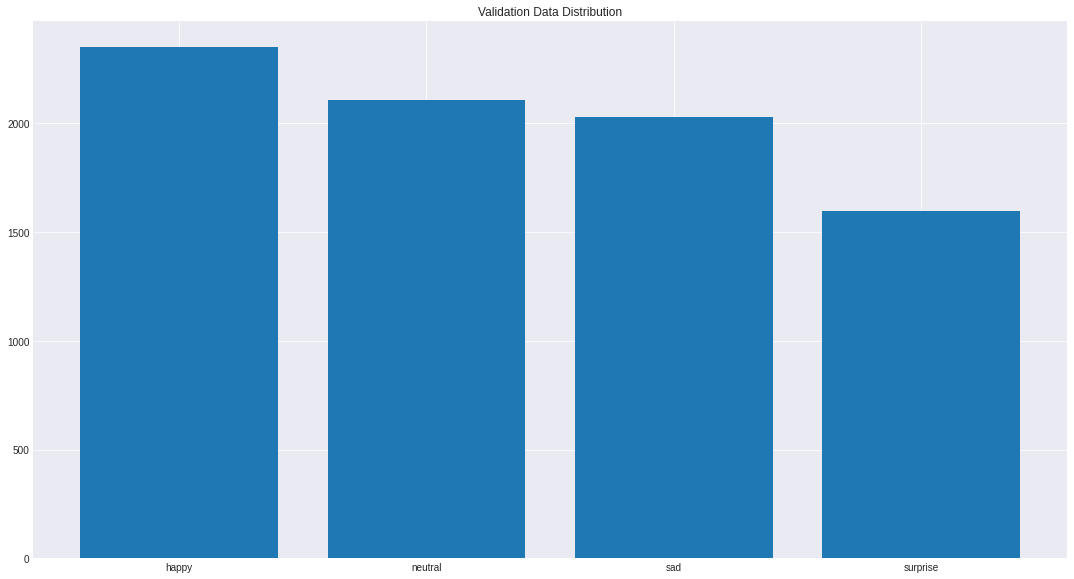

In [ ]:
from collections import Counter

plt.style.use('seaborn-darkgrid')

def category_count(class_items, title):
  
  list_of_classes = [path.parts[-2] for path in class_items]
  d = dict(sorted(Counter(list_of_classes).items()))

  fig, ax = plt.subplots(figsize=(15,8))
  fig.tight_layout()

  plt.title(title)
  ax.bar(d.keys(), d.values())

category_count(dls.valid_ds.items, 'Validation Data Distribution')      #visualizing the validation set

In [ ]:
print(len(dls.valid))

189


Viewing augmented data

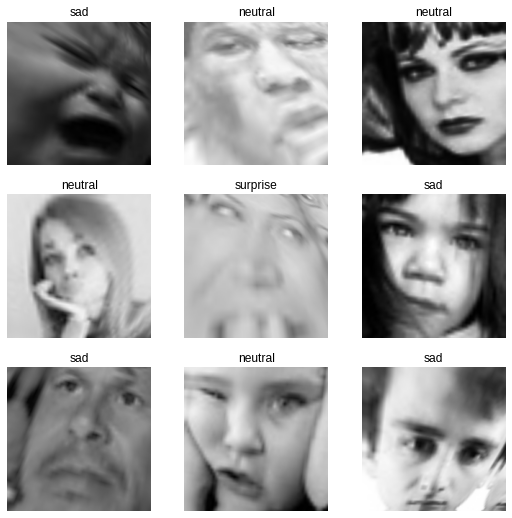

In [ ]:
dls.show_batch(max_n=9)


Model: 'vision_learn' using fast.ai 2 DataLoader, 'vision_learner', and finding best lr ahead of time.

In [ ]:

from fastai.metrics import accuracy
vision_learn = vision_learner(dls, resnet34, metrics=accuracy)        
#vision_learn.lr_find()                                          #finds its own best learning rate. Ideally, you run FIRST, then give to model.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Running 'vision_learn' model with predetermined lr, 15 epochs. Also resnet34.

In [ ]:
vision_learn.fit_one_cycle(15,0.0012022644514217973) #vision_learner is updated from cnn_learner in fast.ai v1

epoch,train_loss,valid_loss,accuracy,time
0,0.781589,0.632052,0.744681,01:04
1,0.765903,0.616649,0.751732,01:03
2,0.772818,0.611900,0.745794,01:03
3,0.733178,0.589567,0.760515,01:03
4,0.720094,0.584854,0.758783,01:02
5,0.724447,0.571942,0.761009,01:04
6,0.720448,0.549175,0.777462,01:03
7,0.705505,0.553345,0.776348,01:03
8,0.702259,0.543393,0.785750,01:03
9,0.674174,0.536343,0.779441,01:03


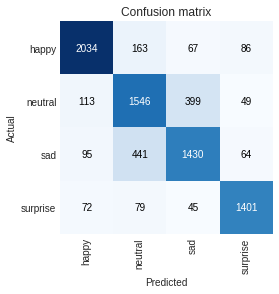

In [ ]:
# PLOTTING A CONFUSION MATRIX from vision_learn model

interpV = ClassificationInterpretation.from_learner(vision_learn)
interpV.plot_confusion_matrix()

In [ ]:
v_learn = vision_learner(dls, resnet34, lr = 0.0006918309954926372, cbs=ShowGraphCallback())


plotting prediciton and accuracy

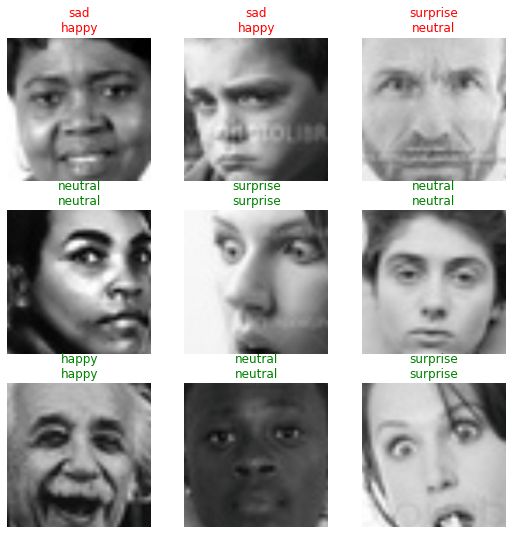

In [ ]:
Learner.show_results(v_learn)


**A callback that updates loss metric in real time with each epoch.**

epoch,train_loss,valid_loss,time
0,1.004948,0.807769,01:01
1,0.835871,0.675005,01:02
2,0.796512,0.634163,01:01
3,0.758574,0.599508,01:02
4,0.740459,0.587865,01:02
5,0.719318,0.580884,01:03
6,0.715153,0.560758,01:02
7,0.688624,0.561926,01:02


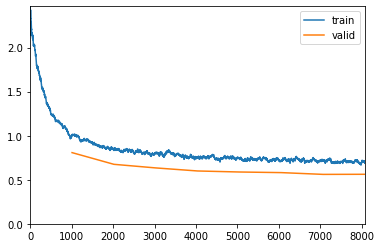

In [ ]:
v_learn = vision_learner(dls, resnet34, lr = 0.0006918309954926372, cbs=ShowGraphCallback())
v_learn.fit(8)

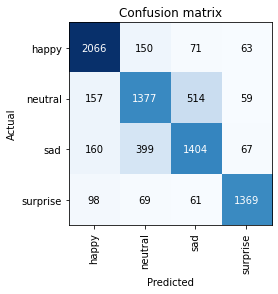

In [ ]:
interp = ClassificationInterpretation.from_learner(v_learn)
interp.plot_confusion_matrix()

**Run validation on test set**

epoch,train_loss,valid_loss,time
0,1.080454,0.865904,46:16


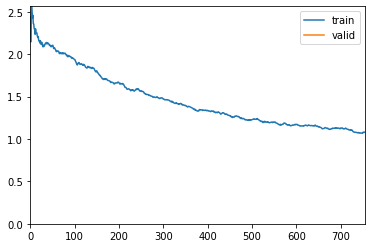

In [ ]:
v_learn = vision_learner(dls, resnet34, lr = 0.0006918309954926372, cbs=ShowGraphCallback())
v_learn.fit(1)

In [ ]:
v_learn.validate() #this is loss validation, is the same

(#1) [0.8659037351608276]

Same model, accuracy metrics, then running validation 

In [ ]:
av_learn = vision_learner(dls, resnet34, lr = 0.0006918309954926372, metrics=accuracy)
av_learn.fit(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.093427,0.835757,0.658282,02:25
1,0.900638,0.703117,0.710740,02:23
2,0.838726,0.647141,0.728777,02:23
3,0.819190,0.624823,0.748966,02:22


In [ ]:
av_learn.validate()

(#2) [0.6248233914375305,0.7489657402038574]

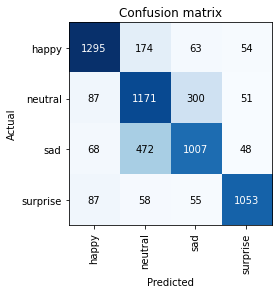

In [ ]:
interp_av = ClassificationInterpretation.from_learner(av_learn)
interp_av.plot_confusion_matrix()

Plotting top losses for second vision_learn model

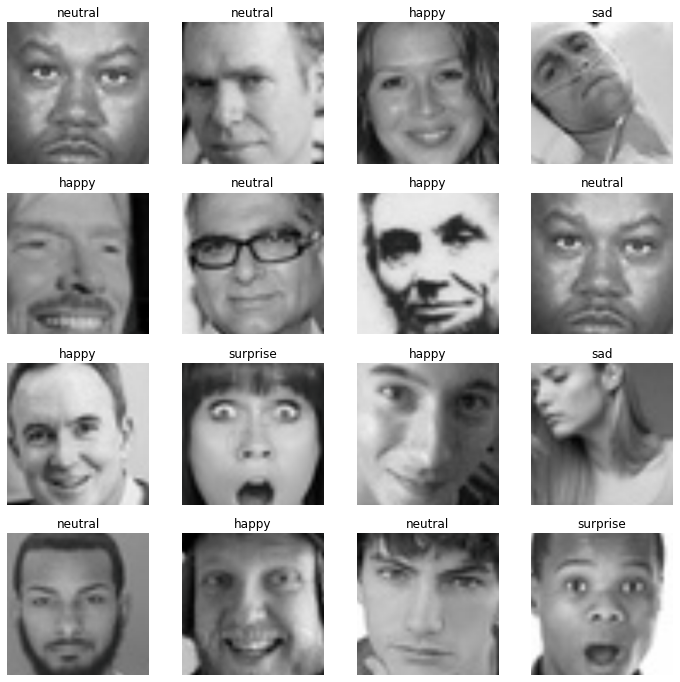

In [ ]:
test_dls.valid.show_batch(max_n=16, nrows=4)

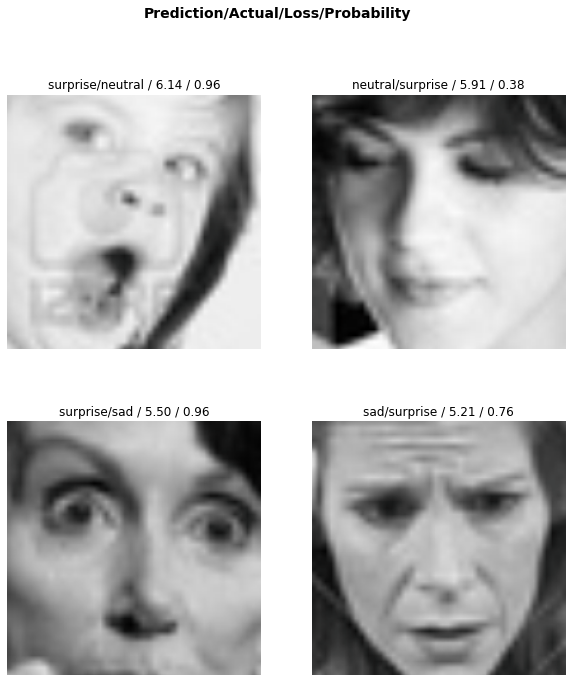

In [ ]:
interp_av.plot_top_losses(4, figsize=(10,11))    #it has been said that the labeling for this dataset is imperfect

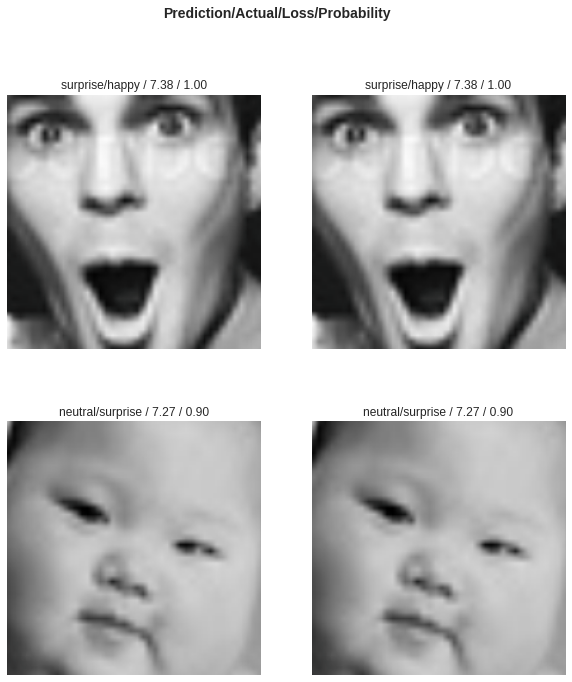

In [ ]:
interpV.plot_top_losses(4, figsize=(10,11))

**A sample of validation images**

There is surely more, and digging in to various callbacks, etc., is a great way to explore what else can be achieved. Enjoy!

Here's the fastai2 vision colab page, for more resources
https://colab.research.google.com/github/tezike/blog/blob/master/_notebooks/2020-04-01-Understanding-fastai-vision.ipynb#scrollTo=kXVOD12EkBn8